# Import Libraries

In [1]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import sklearn
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch import linalg as LA

import timm

from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [2]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

In [3]:
# timm.list_models(pretrained=True)

# Config

In [63]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost
TRAIN_MODE = True # Set True when training. Set False while evaluating
OUTPUT_DIR = '/kaggle/input/maxvit-rmlp-tiny-rw-256-l0-5' if not TRAIN_MODE else '/kaggle/working' # Load trained model weights if TRAIN_MODE = False
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [256, 256]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 25 if NOT_DEBUG else 2
MODEL_NAME = "maxvit_rmlp_tiny_rw_256"  # MaxViT

# Set efficientnet_b5.sw_in12k - EfficientNet
# Set densenet201.tv_in1k - DenseNet
# Set resnet34.a1_in1k - ResNet

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 100

LR = 1e-3 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True
LAMBDA = 0.1 # Hyperparameter that controls the sparsity of attention map

# Stack size for each views
orientation_depth = {
        'a': 10,
        's1': 10,
        's2': 10
        }

In [5]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Open Dataframes

In [6]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [7]:
key = 'right_subarticular_stenosis'
df[key + '_l1_l2'].value_counts() + df[key + '_l2_l3'].value_counts() + df[key + '_l3_l4'].value_counts() + \
df[key + '_l4_l5'].value_counts() + df[key + '_l5_s1'].value_counts()

right_subarticular_stenosis_l1_l2
Normal/Mild    6869
Moderate       1825
Severe          927
Name: count, dtype: int64

In [8]:
df = df.dropna(how = 'any', axis = 0)

In [9]:
# df = df.fillna(-100)

In [10]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_34/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

targets = df.columns.tolist()[1:]

# Define Dataset

In [12]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, orientation_depth['s1'], 1):
            try:
                p = f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, orientation_depth['s2'], 1):
            try:
                p = f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'/kaggle/input/rsna-v224/_output_/cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

# Define Data Augmentaion

In [13]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Define Model

In [15]:
def get_output_shape(model, image_dim):
    return int(model(torch.rand(*(image_dim))).data.shape[-1])
    
class LocalAttention(nn.Module):
    def __init__(self, in_channels, kernel_size=3, stride=1, padding=1):
        super(LocalAttention, self).__init__()
        # 1x1 convolution to reduce the channel dimension to 1 (attention map)
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        # x: input feature map (batch_size, channels, height, width)
        batch_size, channels, height, width = x.size()

        # Apply a 1x1 convolution to compute attention scores for each spatial location
        attention = torch.sigmoid(self.conv(x))  # (batch_size, in_channels, height, width)

        # Apply the attention map to the feature map

        return attention
    
class FeatureExtractor(nn.Module):
    def __init__(self, backbone, channels):
        super(FeatureExtractor, self).__init__()
        self.maps = None
        self.attention = LocalAttention(channels)
        self.feature_extractor = timm.create_model(
                                            backbone,
                                            pretrained = True, 
                                            features_only = False,
                                            in_chans = channels,
                                            num_classes = 0,
                                            global_pool = 'max'
                                        )
        
    def forward(self, x):
        self.maps = self.attention(x)
        x = self.feature_extractor(x * self.maps)
        return x
    
class Classifier(nn.Module):
    def __init__(self, backbone):
        super(Classifier, self).__init__()
        self.axial_extractor = FeatureExtractor(backbone, orientation_depth['a'])
        self.s1_extractor = FeatureExtractor(backbone, orientation_depth['s1'])
        self.s2_extractor = FeatureExtractor(backbone, orientation_depth['s2'])

        self.in_features = get_output_shape(self.axial_extractor, (1, orientation_depth['a'], *IMG_SIZE)) + \
    get_output_shape(self.s1_extractor, (1, orientation_depth['s1'], *IMG_SIZE)) + \
        get_output_shape(self.s2_extractor, (1, orientation_depth['s2'], *IMG_SIZE))
        
        self.classifier = nn.Linear(self.in_features, 75)
        
        self.activation = nn.ReLU()
        
    def forward(self, axial_slices, s1_slices, s2_slices):
        axial_features = self.axial_extractor(axial_slices)
        s1_features = self.s1_extractor(s1_slices)
        s2_features = self.s2_extractor(s2_slices)
        
        x = torch.cat((axial_features, s1_features, s2_features), axis = 1)
        x = self.activation(x)
        
        return self.classifier(x)

# Training

In [17]:
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

In [ ]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE*2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = Classifier(MODEL_NAME) # RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=num_total_steps,
                                            num_cycles=num_cycles)

    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):  
                x = x.to(device)
                t = t.to(device)
                
                with autocast:
                    loss = 0
                    y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS
                        loss += LAMBDA * (model.axial_extractor.maps.abs().mean() + model.s1_extractor.maps.abs().mean() + model.s2_extractor.maps.abs().mean())
                        
                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC
    
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)
    
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
                
                if (idx + 1) % GRAD_ACC == 0:
                    print(f'Epoch: {epoch}, Batch: {(idx // GRAD_ACC) + 1}, Train loss: {total_loss / (idx + 1)}, Learning rate: {optimizer.param_groups[0]["lr"]:.3e}')
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()         
                        
        print(f'Epoch: {epoch}:-')
        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        total_loss = 0
        y_preds = []
        labels = []
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
 
                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
                        
                        total_loss += loss.item()   
    
        val_loss = total_loss/len(valid_dl)
        
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)
        y_pred_np = y_preds.softmax(1).numpy()
        labels_np = labels.numpy()
        y_pred_nan = np.zeros((y_preds.shape[0], 1))
        y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
        
        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        if val_loss < best_loss or val_wll < best_wll:
            
            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')                
                
            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
            
            if device!='cuda:0':
                model.to(device)
            
        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break  
    # break                    

# Calculation CV

In [ ]:
cv = 0
y_preds_folds = {}
labels_folds = {}
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    y_preds = []
    labels = []
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = Classifier(MODEL_NAME) # RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y = model(x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :], x[:, :orientation_depth['s1'], :, :], x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :])
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

    y_preds = torch.cat(y_preds)
    labels = torch.cat(labels)

    y_preds_folds[f"fold-{fold}"] = y_preds
    labels_folds[f"fold-{fold}"] = labels

In [ ]:
from sklearn.metrics import classification_report

for fold in range(N_FOLDS):
    print(f"Fold-{fold}\n")
    
    y_preds = y_preds_folds[f"fold-{fold}"]
    labels = labels_folds[f"fold-{fold}"]
    
    y_pred_np = y_preds.softmax(1).numpy()
    labels_np = labels.numpy()
    
    print(classification_report(labels_np, y_pred_np.argmax(1), target_names = ['Normal/Mild', 'Moderate', 'Severe']))
    print('\n')
    print('#'*30)
    print('\n')

In [ ]:
for fold in range(N_FOLDS):
    print(f"Fold-{fold}\n")
    
    y_preds = y_preds_folds[f"fold-{fold}"]
    labels = labels_folds[f"fold-{fold}"]
    
    y_pred_np = y_preds.softmax(1).numpy()
    labels_np = labels.numpy()
    
    print(f"Weighted log loss: {criterion2(y_preds, labels)}")
    print("Confusion Matrix:")
    print(confusion_matrix(labels_np, y_pred_np.argmax(1)))
    print(f"ROC AUC: {roc_auc_score(labels_np, y_pred_np,multi_class= 'ovo')}")
    print('\n')
    print('#'*30)
    print('\n')

# Global Attention Maps

In [64]:
model = Classifier(MODEL_NAME)
fname = f'{OUTPUT_DIR}/best_wll_model_fold-{0}.pt'
model.load_state_dict(torch.load(fname))
model.to(device) 

Classifier(
  (axial_extractor): FeatureExtractor(
    (attention): LocalAttention(
      (conv): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (feature_extractor): MaxxVit(
      (stem): Stem(
        (conv1): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (stages): Sequential(
        (0): MaxxVitStage(
          (blocks): Sequential(
            (0): MaxxVitBlock(
              (conv): MbConvBlock(
                (shortcut): Downsample2d(
                  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
                  (expand): Identity()
                )
                (pre_norm): BatchNormAct2d(
                  64, eps=

In [65]:
valid_ds = RSNA24Dataset(df, phase='valid', transform=transforms_val)
valid_dl = DataLoader(
            valid_ds,
            batch_size=3,
            shuffle=True,
            pin_memory=True,
            drop_last=False,
            num_workers=N_WORKERS
            )

In [66]:
model.eval()
with tqdm(valid_dl, leave=True) as pbar:
    with torch.no_grad():
        for idx, (x, t) in enumerate(pbar):

            x = x.to(device)
            t = t.to(device)
            
            axial_slices = x[:, orientation_depth['s1'] + orientation_depth['s2']:orientation_depth['a'] + orientation_depth['s1'] + orientation_depth['s2'], :, :]
            s1_slices = x[:, :orientation_depth['s1'], :, :]
            s2_slices = x[:, orientation_depth['s1']:orientation_depth['s1'] + orientation_depth['s2'], :, :]

            with autocast:
                axial_maps = model.axial_extractor.attention(axial_slices)
                s1_maps = model.s1_extractor.attention(s1_slices)
                s2_maps = model.s2_extractor.attention(s2_slices)
                break

  0%|          | 0/597 [00:03<?, ?it/s]


In [67]:
axial_slices = axial_slices.cpu().numpy()
s1_slices = s1_slices.cpu().numpy()
s2_slices = s2_slices.cpu().numpy()

axial_maps = axial_maps.cpu().numpy()
s1_maps = s1_maps.cpu().numpy()
s2_maps = s2_maps.cpu().numpy()

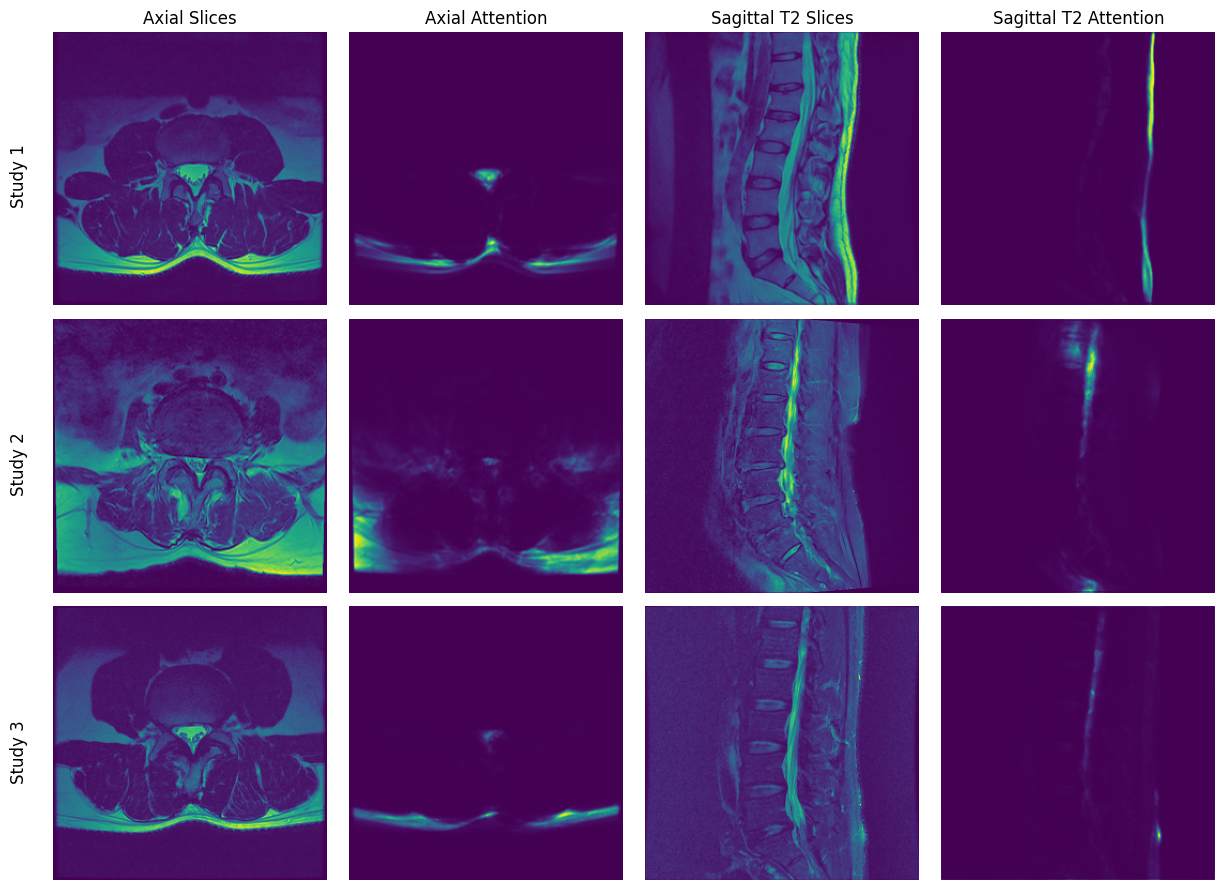

In [76]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for r in range(3):
    for c in range(4):
        img = None
        if c == 0:
            img = axial_slices[r, 5]
        elif c == 1:
            img = axial_maps[r, 0]
        elif c == 2:
            img = s2_slices[r, 5]
        elif c == 3:
            img = s2_maps[r, 0]
        # Read and display each image
        axes[r, c].imshow(img)
        axes[r, c].axis("off")  # Hide axes for a cleaner look

axes[0, 0].set_title('Axial Slices')
axes[0, 1].set_title('Axial Attention')
axes[0, 2].set_title('Sagittal T2 Slices')
axes[0, 3].set_title('Sagittal T2 Attention')

for row_idx, row_label in enumerate(['Study 1', 'Study 2', 'Study 3']):
    # Position the text in the middle of each row
    fig.text(-0.02, 0.96 - (2*row_idx+1)*0.16, row_label, fontsize=12, va='center', ha='left', rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig('destination_path.eps', format='eps', bbox_inches='tight')
plt.savefig('destination_path.png', bbox_inches='tight')
plt.show()

# S1 Attention

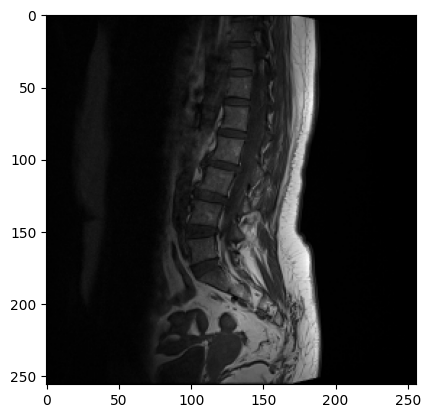

In [38]:
plt.imshow(s1_slices.cpu().numpy()[2, 5], cmap = 'gray')

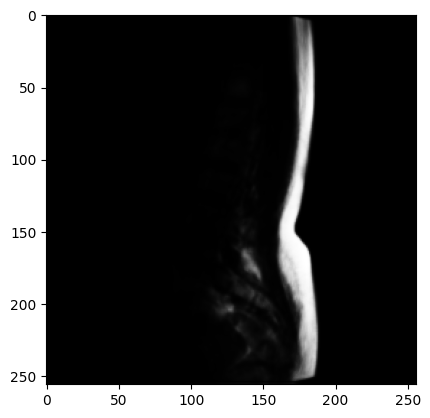

In [39]:
plt.imshow(s1_maps.cpu().numpy()[2, 0], cmap = 'gray')

# S2 Attention

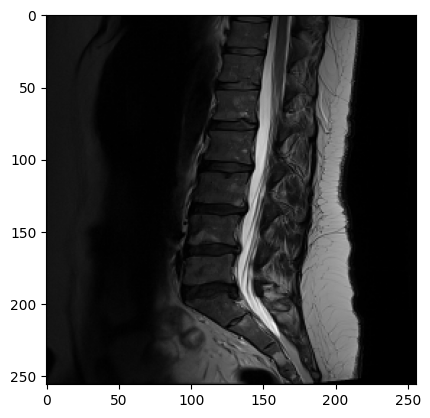

In [40]:
plt.imshow(s2_slices.cpu().numpy()[1, 5], cmap = 'gray')

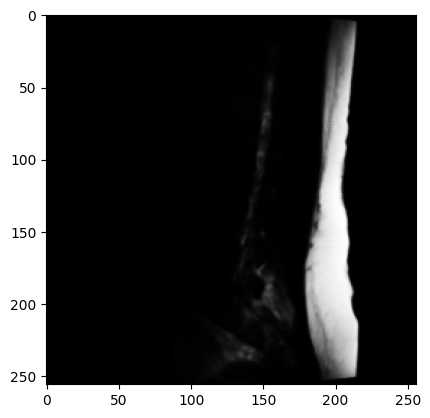

In [41]:
plt.imshow(s2_maps.cpu().numpy()[1, 0], cmap = 'gray')

# Axial Attention

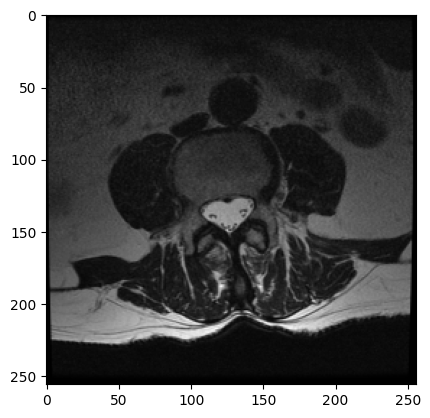

In [42]:
plt.imshow(axial_slices.cpu().numpy()[0, 5], cmap = 'gray')

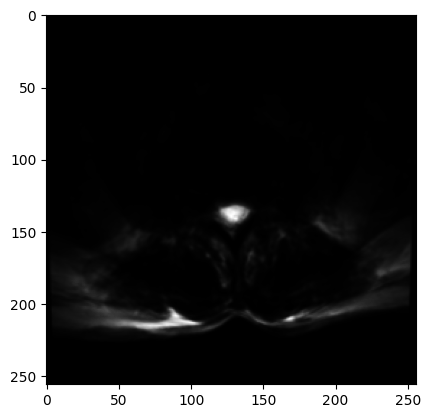

In [43]:
plt.imshow(axial_maps.cpu().numpy()[0, 0], cmap = 'gray')